Для задачи семантической сегментации просто натренировать модель

## Load the data

Dataset is a part of [midv500](https://arxiv.org/abs/1807.05786) dataset.
For a simplicity all quadrangles converted to png masks.



In [ ]:
! wget http://fmb.images.gan4x4.ru/hse/midv500p.zip
! unzip -q midv500p.zip

--2025-02-06 20:16:45--  http://fmb.images.gan4x4.ru/hse/midv500p.zip
Resolving fmb.images.gan4x4.ru (fmb.images.gan4x4.ru)... 212.24.105.216
Connecting to fmb.images.gan4x4.ru (fmb.images.gan4x4.ru)|212.24.105.216|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9183651 (8.8M) [application/zip]
Saving to: ‘midv500p.zip’

midv500p.zip        100%[===================>]   8.76M  2.23MB/s    in 5.2s    

2025-02-06 20:16:51 (1.70 MB/s) - ‘midv500p.zip’ saved [9183651/9183651]



Dataset.
You can use it without modification

In [ ]:
from torch.utils.data import Dataset
from torchvision import tv_tensors
from PIL import Image, ImageFile
from torchvision.io import read_image
import glob

# To bypass error on corrupted files: https://stackoverflow.com/questions/12984426/pil-ioerror-image-file-truncated-with-big-images
# ImageFile.LOAD_TRUNCATED_IMAGES = False


class MaskDataset(Dataset):
    def __init__(
        self,
        train_part=True,
        transform=None,  # for image only
        transforms=None,  # for image and mask
        target_transform=None,  # for mask only
        path="midv500p",
    ):
        self.transform = transform
        self.transforms = transforms
        self.target_transform = target_transform
        path += "/train" if train_part else "/val"
        files = glob.glob(path + "/image/*")
        self.loaded_images = []
        self.loaded_masks = []

        for filename in files:  # cache all data in memory
            self.loaded_images.append(read_image(filename) / 255)
            mask_fn = filename.replace("image", "mask").replace("jpg", "png")
            self.loaded_masks.append(read_image(mask_fn) / 255)

    def __getitem__(self, i):
        img = self.loaded_images[i]
        mask = self.loaded_masks[i]
        if self.transform is not None:
            img = self.transform(img)
        if self.transforms is not None:
            img, mask = self.transforms(tv_tensors.Image(img), tv_tensors.Mask(mask))
        if self.target_transform is not None:
            mask = self.target_transform(mask)
        return img, mask

    def __len__(self):
        return len(self.loaded_images)

Dataloaders initialization

In [ ]:
import torch
from torchvision.transforms import v2
from torch.utils.data import DataLoader


v2_transforms = v2.Compose(
    [
        v2.Resize((224, 224), antialias=True),  # antialias to suppress warning
        v2.ToDtype(torch.float32, scale=True),
    ]
)


trainset = MaskDataset(train_part=True, transforms=v2_transforms)
valset = MaskDataset(train_part=False, transforms=v2_transforms)

train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=4, shuffle=False, num_workers=2)


Lets show some data

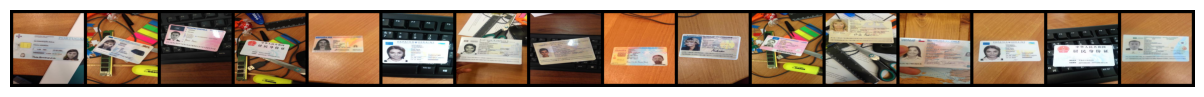

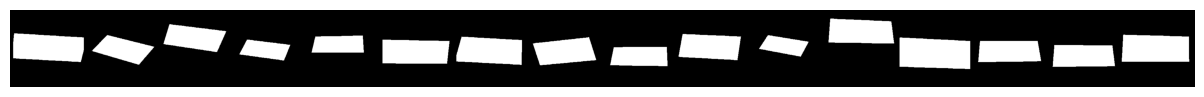

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

def show(batch, cols=16):
    cols = min(cols, len(batch))
    img_grid = make_grid(batch[:cols], padding=10, nrow=cols)
    plt.figure(figsize=(cols, 1))
    plt.axis("off")
    plt.imshow(np.transpose((img_grid * 255).numpy().astype(np.uint8), (1, 2, 0)))


images, masks = next(iter(train_loader))

show(images)
show(masks)

Соединил ячейки. Сделал MiniUnet с сжатием, обработкой признаков, восстановлением и выходной маской.

Выбрал бин кроссэнтропию с логитами и оптимизатор Adam.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class MiniUnet(nn.Module):
    def __init__(self, num_classes=1):
        super(MiniUnet, self).__init__()

        # Downsample
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2)

        # Bottleneck
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Upsample
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Output layer
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.pool1(x1)

        x3 = self.conv2(x2)
        x4 = self.pool2(x3)

        x5 = self.conv3(x4)

        x6 = self.up1(x5)
        x6 = torch.cat([x6, x3], dim=1)
        x6 = self.conv4(x6)

        x7 = self.up2(x6)
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.conv5(x7)

        out = self.final(x7)
        return out

mini_unet = MiniUnet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mini_unet.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(mini_unet.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

train_model(mini_unet, train_loader, criterion, optimizer, epochs=50)


Epoch 1, Loss: 0.4559
Epoch 2, Loss: 0.2821
Epoch 3, Loss: 0.2693
Epoch 4, Loss: 0.2749
Epoch 5, Loss: 0.2677
Epoch 6, Loss: 0.2513
Epoch 7, Loss: 0.2361
Epoch 8, Loss: 0.2433
Epoch 9, Loss: 0.2382
Epoch 10, Loss: 0.2276
Epoch 11, Loss: 0.2269
Epoch 12, Loss: 0.2260
Epoch 13, Loss: 0.2300
Epoch 14, Loss: 0.2184
Epoch 15, Loss: 0.2144
Epoch 16, Loss: 0.2181
Epoch 17, Loss: 0.2206
Epoch 18, Loss: 0.2147
Epoch 19, Loss: 0.2105
Epoch 20, Loss: 0.2046
Epoch 21, Loss: 0.1930
Epoch 22, Loss: 0.1943
Epoch 23, Loss: 0.1847
Epoch 24, Loss: 0.1774
Epoch 25, Loss: 0.1660
Epoch 26, Loss: 0.1602
Epoch 27, Loss: 0.1575
Epoch 28, Loss: 0.1529
Epoch 29, Loss: 0.1426
Epoch 30, Loss: 0.1310
Epoch 31, Loss: 0.1212
Epoch 32, Loss: 0.1259
Epoch 33, Loss: 0.1126
Epoch 34, Loss: 0.1018
Epoch 35, Loss: 0.1205
Epoch 36, Loss: 0.1228
Epoch 37, Loss: 0.0979
Epoch 38, Loss: 0.0867
Epoch 39, Loss: 0.0812
Epoch 40, Loss: 0.0933
Epoch 41, Loss: 0.0834
Epoch 42, Loss: 0.0764
Epoch 43, Loss: 0.0695
Epoch 44, Loss: 0.08

## Train the model

Select appopriate loss and metric


In [ ]:
mini_unet = MiniUnet()

# Put your code here

# Display results

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def show_valset_pred(model, cols=16):
    model.to(device)
    images, pred_masks = [], []
    try:
        tmp = valset.transform
        valset.transform = None
        for batch in valset:
            with torch.no_grad():
                img, mask = batch
                images.append(img.unsqueeze(0))
                output = model(img.unsqueeze(0).to(device))
                pred_masks.append(output.cpu())

    finally:
        valset.transform = tmp
    show(torch.stack(images).squeeze()[:cols, ...])
    binary_mask = torch.stack(pred_masks) > 0.5
    show(binary_mask.squeeze(1).float()[:cols, ...])

Потренил сеть на 50 эпохах, вот результаты:

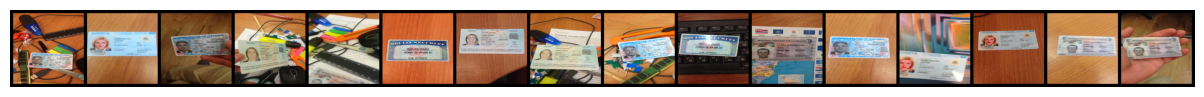

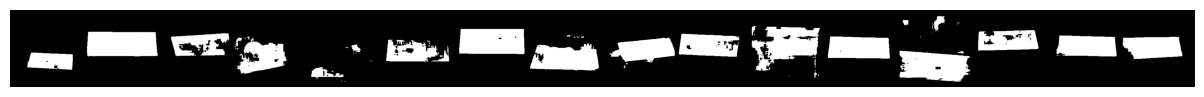

In [ ]:
show_valset_pred(mini_unet, 16)

Результат: получился не плохой, но и не прям успешный. Можно было бы поиграться с аугментациями, добавить еще 100-150 эпох или сменить BCEWithLogitsLoss на Dice Loss